# 자율주행 시스템 스레드 기반 아키텍처 Prototype (prototype1.ipynb)

본 노트북은 `doc.md`에 설계된 스레드 기반 자율주행 시스템 아키텍처의 프로토타입 코드입니다. 각 주요 기능을 별도의 스레드로 분리하여 병렬 처리를 시뮬레이션하고, 향후 `.py` 파일로의 변환을 용이하게 하는 것을 목표로 합니다.

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# =============================================
# 본 프로그램은 2025 제8회 국민대 자율주행 경진대회에서
# 예선과제를 수행하기 위한 파일입니다. 
# 예선과제 수행 용도로만 사용가능하며 외부유출은 금지됩니다.
# =============================================
import numpy as np
import cv2, rospy, time, os, math
from sensor_msgs.msg import Image
from xycar_msgs.msg import XycarMotor
from cv_bridge import CvBridge
from sensor_msgs.msg import LaserScan
import matplotlib.pyplot as plt
import threading
import queue


: 

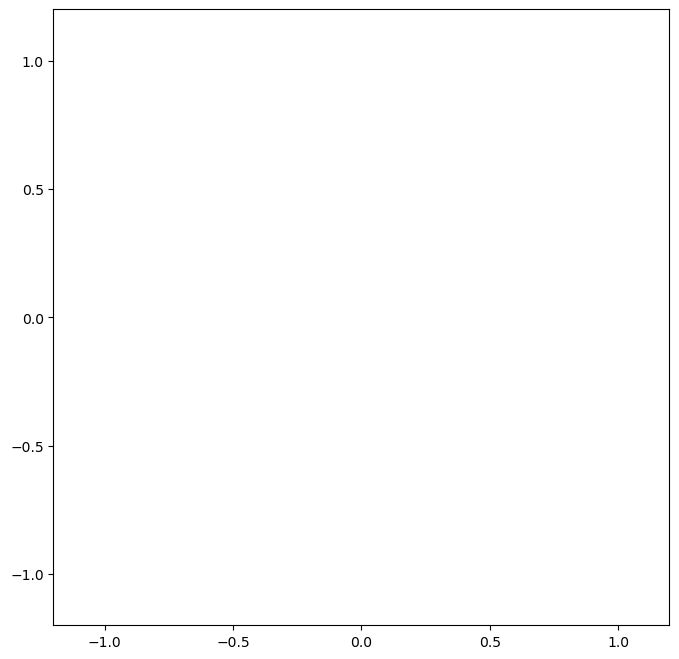

In [2]:

# =============================================
# 프로그램에서 사용할 변수, 저장공간 선언부
# =============================================
# ROS 콜백에서 직접 업데이트되는 전역 변수 (스레드 안전성 고려 필요)
image = np.empty(shape=[0])  # 카메라 이미지를 담을 변수
ranges = None  # 라이다 데이터를 담을 변수

# 모터 관련 변수
motor = None  # 모터노드
motor_msg = XycarMotor()  # 모터 토픽 메시지

# OpenCV 브릿지
bridge = CvBridge()  # OpenCV 함수를 사용하기 위한 브릿지

# 스레드 간 데이터 공유를 위한 큐
# maxsize=1로 설정하여 항상 최신 데이터만 유지하도록 시도
image_queue = queue.Queue(maxsize=1) 
lidar_queue = queue.Queue(maxsize=1) 
steering_angle_queue = queue.Queue(maxsize=1)
obstacle_info_queue = queue.Queue(maxsize=1)
driving_command_queue = queue.Queue(maxsize=1)

# 스레드 종료를 위한 이벤트 플래그
exit_flag = threading.Event()

# =============================================
# 주행 관련 상수 설정
# =============================================
FIX_SPEED = 10  # 기본 주행 속도
MAX_ANGLE = 50.0 # 최대 조향각 (예시)
MIN_ANGLE = -50.0 # 최소 조향각 (예시)

# =============================================
# 카메라 관련 상수 설정
# =============================================
IMG_WIDTH = 640
IMG_HEIGHT = 480
ROI_START_ROW = 300 # ROI 시작 행 (예시 값, 실제 환경에 맞게 조정 필요)
ROI_END_ROW = 400   # ROI 끝 행 (예시 값, 실제 환경에 맞게 조정 필요)
CANNY_LOW_THRESHOLD = 50 # Canny 엣지 검출 낮은 임계값 (예시)
CANNY_HIGH_THRESHOLD = 150 # Canny 엣지 검출 높은 임계값 (예시)
HOUGH_THRESHOLD = 50 # Hough 변환 임계값 (예시)
HOUGH_MIN_LINE_LENGTH = 50 # Hough 변환 최소 선 길이 (예시)
HOUGH_MAX_LINE_GAP = 5 # Hough 변환 최대 선 간격 (예시)

# =============================================
# 라이다 관련 상수 설정
# =============================================
SCAN_AREA_THRESHOLD = 0.2 # 장애물 감지 거리 임계값 (m) (예시)
SCAN_ANGLE_RANGE = 30 # 장애물 감지 각도 범위 (중심 기준 양쪽 각도) (예시)

# =============================================
# 라이다 스캔정보로 그림을 그리기 위한 변수
# =============================================
# Jupyter 환경에서는 Matplotlib GUI 관리가 다를 수 있습니다.
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-1.2, 1.2) # m 단위로 변경
ax.set_ylim(-1.2, 1.2) # m 단위로 변경
ax.set_aspect('equal')
lidar_points, = ax.plot([], [], 'bo')

# =============================================
# 콜백함수 - 카메라 토픽을 처리하는 콜백함수
# =============================================
def usbcam_callback(data):
    global image # 전역 변수 업데이트
    img = bridge.imgmsg_to_cv2(data, "bgr8")
    image = img 
    try:
        # 큐가 꽉 찼으면 이전 데이터 버림
        if image_queue.full():
            image_queue.get_nowait()
        image_queue.put_nowait(img) # 논블로킹으로 큐에 삽입
    except queue.Full:
        pass # 예외 발생 시 무시
    except Exception as e:
        print(f"Error in usbcam_callback: {e}")

# =============================================
# 콜백함수 - 라이다 토픽을 받아서 처리하는 콜백함수
# =============================================
def lidar_callback(data):
    global ranges # 전역 변수 업데이트
    current_ranges = np.array(data.ranges[0:360]) # numpy 배열로 변환
    ranges = current_ranges 
    try:
        # 큐가 꽉 찼으면 이전 데이터 버림
        if lidar_queue.full():
            lidar_queue.get_nowait()
        lidar_queue.put_nowait(current_ranges) # 논블로킹으로 큐에 삽입
    except queue.Full:
        pass # 예외 발생 시 무시
    except Exception as e:
        print(f"Error in lidar_callback: {e}")

# =============================================
# 모터로 토픽을 발행하는 함수 
# =============================================
def drive(angle, speed):
    motor_msg.angle = float(angle)
    motor_msg.speed = float(speed)
    if motor: # motor 객체가 초기화되었는지 확인
        motor.publish(motor_msg)
    # print(f"Driving: Angle={angle:.2f}, Speed={speed}") # 디버깅 출력)

# =============================================
# 카메라 이미지 전처리 함수
# =============================================
def preprocess_image(img):
    if img is None or img.shape[0] == 0:
        return None
    # ROI 설정
    roi_img = img[ROI_START_ROW:ROI_END_ROW, 0:IMG_WIDTH]
    # 이미지 전처리
    gray = cv2.cvtColor(roi_img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, CANNY_LOW_THRESHOLD, CANNY_HIGH_THRESHOLD)
    return edges

# =============================================
# 차선 검출 함수
# =============================================
def detect_lines(edges):
    if edges is None:
        return None
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, HOUGH_THRESHOLD, 
                            minLineLength=HOUGH_MIN_LINE_LENGTH, maxLineGap=HOUGH_MAX_LINE_GAP)
    return lines

# =============================================
# 차선 정보를 바탕으로 조향각 계산 함수
# =============================================
def calculate_angle_from_lines(lines):
    angle = 0.0
    if lines is not None:
        line_centers = []
        line_slopes = []
        for line in lines:
            x1, y1, x2, y2 = line[0]
            center_x = (x1 + x2) / 2
            line_centers.append(center_x)
            if x2 - x1 != 0:
                slope = (y2 - y1) / (x2 - x1)
                line_slopes.append(slope)

        if line_centers:
            avg_center_x = np.mean(line_centers)
            # 이미지 중앙과의 차이를 이용하여 조향각 계산 (간단한 비례 제어 예시)
            # 오차: 이미지 중앙 (IMG_WIDTH / 2) - 검출된 선들의 평균 중심 x 좌표
            error = (IMG_WIDTH / 2) - avg_center_x
            # 조향각은 오차에 비례하도록 설정 (PID 제어 등을 적용하여 개선 가능)
            angle = error * 0.2 # 0.2는 임의의 비례 상수, 조정 필요

        # 검출된 선들의 기울기를 활용하여 조향각 보정 (예시)
        if line_slopes:
            avg_slope = np.mean(line_slopes)
            # 기울기가 양수이면 오른쪽으로 치우쳐 있다는 의미, 음수이면 왼쪽으로 치우쳐 있다는 의미
            # 기울기에 따라 조향각을 추가적으로 조정 (예시)
            angle -= avg_slope * 5 # 5는 임의의 상수, 조정 필요


    return angle

# =============================================
# 라이다 데이터 분석 함수
# =============================================
def analyze_lidar_data(lidar_ranges):
    obstacle_detected = False
    if lidar_ranges is not None and len(lidar_ranges) > 0:
        # 전방 일정 각도 범위의 최소 거리를 확인하여 장애물 감지 (예시)
        center_index = len(lidar_ranges) // 2
        # 라이다 각도 범위 계산 (예: -SCAN_ANGLE_RANGE 부터 +SCAN_ANGLE_RANGE)
        # 라이다 데이터의 각도 범위와 인덱스 매핑 확인 필요
        # 여기서는 간단히 중앙 인덱스 기준 좌우 SCAN_ANGLE_RANGE 만큼의 인덱스 범위를 사용
        angle_increment = 360.0 / len(lidar_ranges) # 각도 해상도
        start_angle_idx = int((360 - SCAN_ANGLE_RANGE) / angle_increment) % len(lidar_ranges)
        end_angle_idx = int(SCAN_ANGLE_RANGE / angle_increment) % len(lidar_ranges)

        # 전방 범위 인덱스 리스트 생성
        forward_indices = []
        if start_angle_idx < end_angle_idx:
            forward_indices = list(range(start_angle_idx, end_angle_idx + 1))
        else:
            forward_indices = list(range(start_angle_idx, len(lidar_ranges))) + list(range(0, end_angle_idx + 1))

        # 전방 범위 내 최소 거리 확인
        min_distance = float('inf')
        for i in forward_indices:
             # 유효한 거리 값 (0보다 크고 inf보다 작은 값)
             if 0 < lidar_ranges[i] < float('inf'):
                 min_distance = min(min_distance, lidar_ranges[i])

        # 장애물 감지 임계값과 비교
        if min_distance < SCAN_AREA_THRESHOLD:
            obstacle_detected = True
            # print(f"Obstacle detected at {min_distance:.2f} m") # 디버깅 출력)

    return obstacle_detected

# =============================================
# 주행 명령 결정 함수 (카메라 및 라이다 데이터 융합)
# =============================================
def determine_driving_command(image_angle, obstacle_detected):
    angle = image_angle
    speed = FIX_SPEED

    # 장애물 감지 시 속도 제어 (예시)
    if obstacle_detected:
        speed = 0 # 장애물 감지 시 정지 (예시)
        # TODO: 장애물 회피 로직 추가 필요

    # 조향각 범위 제한
    angle = max(MIN_ANGLE, min(MAX_ANGLE, angle))

    return angle, speed

# =============================================
# 스레드 함수들
# =============================================
def lane_detection_thread_func():
    print("Lane detection thread started")
    while not exit_flag.is_set():
        current_image = None
        try:
            # 큐에서 최신 이미지 가져오기 (논블로킹, 없으면 예외 발생)
            current_image = image_queue.get_nowait()
        except queue.Empty:
            # 큐가 비어있으면 잠시 대기 후 다시 시도
            time.sleep(0.01)
            continue # 다음 루프
        except Exception as e:
            print(f"Error getting image from queue in lane_detection_thread: {e}")
            time.sleep(0.1)
            continue
        
        if current_image is not None and current_image.shape[0] > 0:
            try:
                edge_image = preprocess_image(current_image)
                lines = detect_lines(edge_image)
                calculated_angle = calculate_angle_from_lines(lines)
                
                try:
                    # 큐가 꽉 찼으면 이전 데이터 버림
                    if steering_angle_queue.full():
                        steering_angle_queue.get_nowait()
                    steering_angle_queue.put_nowait(calculated_angle)
                except queue.Full:
                    pass # 예외 발생 시 무시
                except Exception as e:
                    print(f"Error putting angle to queue in lane_detection_thread: {e}")

                # 디버깅용 이미지 표시 (Jupyter 환경에서는 주의 필요)
                cv2.imshow("Edges_Thread", edge_image)
                cv2.waitKey(1)

            except Exception as e:
                print(f"Error processing image in lane_detection_thread: {e}")
                time.sleep(0.1) # 오류 발생 시 잠시 대기
        else:
            time.sleep(0.01)

def obstacle_detection_thread_func():
    print("Obstacle detection thread started")
    while not exit_flag.is_set():
        current_ranges = None
        try:
            # 큐에서 최신 라이다 데이터 가져오기 (논블로킹)
            current_ranges = lidar_queue.get_nowait()
        except queue.Empty:
            time.sleep(0.01)
            continue
        except Exception as e:
            print(f"Error getting lidar from queue in obstacle_detection_thread: {e}")
            time.sleep(0.1)
            continue
        
        if current_ranges is not None and len(current_ranges) > 0:
            try:
                obstacle_detected = analyze_lidar_data(current_ranges)
                try:
                    # 큐가 꽉 찼으면 이전 데이터 버림
                    if obstacle_info_queue.full():
                        obstacle_info_queue.get_nowait()
                    obstacle_info_queue.put_nowait(obstacle_detected)
                except queue.Full:
                    pass # 예외 발생 시 무시
                except Exception as e:
                    print(f"Error putting obstacle info to queue in obstacle_detection_thread: {e}")

            except Exception as e:
                print(f"Error analyzing lidar data in obstacle_detection_thread: {e}")
                time.sleep(0.1)
        else:
            time.sleep(0.01)

def decision_making_thread_func():
    print("Decision making thread started")
    # 초기값 설정
    current_calculated_angle = 0.0
    current_obstacle_detected = False
    while not exit_flag.is_set():
        try:
            # 최신 데이터 가져오기 (논블로킹, 없으면 이전 값 유지)
            try:
                current_calculated_angle = steering_angle_queue.get_nowait()
            except queue.Empty:
                pass 

            try:
                current_obstacle_detected = obstacle_info_queue.get_nowait()
            except queue.Empty:
                pass 

            new_angle, new_speed = determine_driving_command(current_calculated_angle, current_obstacle_detected)
            
            try:
                 # 큐가 꽉 찼으면 이전 데이터 버림
                if driving_command_queue.full():
                    driving_command_queue.get_nowait()
                driving_command_queue.put_nowait((new_angle, new_speed))
            except queue.Full:
                pass # 예외 발생 시 무시
            except Exception as e:
                print(f"Error putting driving command to queue in decision_making_thread: {e}")

            time.sleep(0.02) # 판단 주기 조절 (예: 50Hz)
        except Exception as e:
            print(f"Error in decision_making_thread: {e}")
            time.sleep(0.1)

def control_thread_func():
    print("Control thread started")
    while not exit_flag.is_set():
        try:
            # 명령 대기 (타임아웃 설정)
            angle, speed = driving_command_queue.get(timeout=0.1) 
            drive(angle, speed)
        except queue.Empty:
            # 명령이 없을 경우 잠시 대기
            time.sleep(0.01)
        except Exception as e:
            print(f"Error in control_thread: {e}")
            time.sleep(0.1)

# 시각화 스레드는 Jupyter 환경에서 복잡하므로, 여기서는 간단히 스레드 함수만 정의하고
# 실제 시각화는 메인 스레드 또는 별도의 노트북 셀에서 처리하는 것을 권장합니다.
def visualization_thread_func():
    print("Visualization thread started (Placeholder)")
    while not exit_flag.is_set():
        # 시각화 로직 (예: 큐에서 데이터 가져와서 출력)
        # try:
        #     current_angle, current_speed = driving_command_queue.get_nowait()
        #     print(f"[VIS] Angle: {current_angle:.2f}, Speed: {current_speed}")
        # except queue.Empty:
        #     pass
        time.sleep(0.1) # 시각화 업데이트 주기

# =============================================
# 메인 실행 함수
# =============================================
def main():
    global motor, exit_flag

    print("Starting ROS node and subscribers...")
    rospy.init_node('Track_Driver_Threaded_Proto', anonymous=True) # anonymous=True 추가
    rospy.Subscriber("/usb_cam/image_raw/", Image, usbcam_callback, queue_size=1)
    rospy.Subscriber("/scan", LaserScan, lidar_callback, queue_size=1)
    motor = rospy.Publisher('xycar_motor', XycarMotor, queue_size=1)

    print("Waiting for first messages...")
    # 센서 데이터 수신 대기 (rospy.wait_for_message 대신 큐 사용)
    while image_queue.empty() or lidar_queue.empty():
        if rospy.is_shutdown():
            print("ROS shutdown during sensor wait.")
            return
        print("Waiting for sensor data in queues...")
        time.sleep(0.5)

    print("All sensors ready.")
    print("======================================")
    print(" S T A R T I N G T H R E A D S ...")
    print("======================================")

    threads = [
        threading.Thread(target=lane_detection_thread_func, daemon=True),
        threading.Thread(target=obstacle_detection_thread_func, daemon=True),
        threading.Thread(target=decision_making_thread_func, daemon=True),
        threading.Thread(target=control_thread_func, daemon=True),
        # threading.Thread(target=visualization_thread_func, daemon=True) # 시각화 스레드는 선택적으로 실행
    ]

    for t in threads:
        t.start()

    print("Threads started. Running main loop for ROS spin and potential GUI...")

    # 메인 스레드는 ROS 이벤트 처리 및 GUI 관리
    # Jupyter 환경에서는 GUI (cv2.imshow, matplotlib) 처리가 복잡할 수 있습니다.
    # 여기서는 ROS spin 대신 간단히 while 루프와 sleep을 사용합니다.
    # 실제 .py 파일에서는 rospy.spin() 또는 while not rospy.is_shutdown() 사용

    try:
        while not rospy.is_shutdown() and not exit_flag.is_set():
            # 메인 스레드에서 주기적으로 수행할 작업 (예: GUI 업데이트, 상태 모니터링)
            # OpenCV 창 관리는 여기에 추가
            if image is not None and image.shape[0] > 0:
                cv2.imshow("Main_Camera_View", image)
                cv2.waitKey(1)

            # 라이다 시각화 업데이트 (Jupyter 환경에서는 별도 셀에서 실행 권장)
            if ranges is not None and len(ranges) > 0:
                angles_vis = np.linspace(0, 2 * np.pi, len(ranges)) + np.pi / 2
                x_vis = ranges * np.cos(angles_vis)
                y_vis = ranges * np.sin(angles_vis)
                lidar_points.set_data(x_vis, y_vis)
                fig.canvas.draw_idle()
                plt.pause(0.01)

            time.sleep(0.05) # 메인 루프 주기

    except KeyboardInterrupt:
        print("KeyboardInterrupt received in main loop.")
        
    finally:
        print("Setting exit_flag for threads...")
        exit_flag.set() # 스레드 종료 신호
        for t in threads:
            print(f"Joining thread: {t.name}")
            t.join(timeout=2.0) # 스레드 종료 대기
            if t.is_alive():
                print(f"Warning: Thread {t.name} did not terminate in time.")
        
        print("Cleaning up resources...")
        cv2.destroyAllWindows() # OpenCV 창 닫기
        plt.ioff() # Matplotlib 대화형 모드 끄기
        plt.close('all') # Matplotlib 창 닫기
        print("Main loop finished.")


## 실행

In [ ]:

# =============================================
# 노트북 실행 시 메인 함수 호출
# =============================================
if __name__ == '__main__': # .py 파일 변환 시 필요
    try:
        main()
    except rospy.ROSInterruptException:
        print("ROS node interrupted.")
    except Exception as e:
        print(f"Unhandled exception in main: {e}")
        cv2.destroyAllWindows()
        plt.close('all')

# 노트북 환경에서 실행을 위해 직접 호출
# main() # 노트북 셀에서 직접 실행할 때 주석 해제

Starting ROS node and subscribers...
Waiting for first messages...
Waiting for sensor data in queues...
Waiting for sensor data in queues...
Waiting for sensor data in queues...
Waiting for sensor data in queues...
Waiting for sensor data in queues...
Waiting for sensor data in queues...
Waiting for sensor data in queues...
Waiting for sensor data in queues...
Waiting for sensor data in queues...
Waiting for sensor data in queues...
Waiting for sensor data in queues...
Waiting for sensor data in queues...
Waiting for sensor data in queues...
Waiting for sensor data in queues...
Waiting for sensor data in queues...
Waiting for sensor data in queues...
Waiting for sensor data in queues...
Waiting for sensor data in queues...
Waiting for sensor data in queues...
Waiting for sensor data in queues...
Waiting for sensor data in queues...
Waiting for sensor data in queues...
Waiting for sensor data in queues...
Waiting for sensor data in queues...
Waiting for sensor data in queues...
Waiting 

## 실행 방법

1.  ROS 환경이 설정되어 있고 필요한 패키지(`rospy`, `sensor_msgs`, `xycar_msgs`, `cv_bridge`)가 설치되어 있는지 확인합니다.
2.  이 노트북을 실행하기 전에 ROS 마스터 (`roscore`)와 카메라, 라이다 토픽을 발행하는 노드가 실행 중이어야 합니다.
3.  위 코드 셀을 순서대로 실행합니다.
4.  `main()` 함수를 호출하는 마지막 코드 셀의 주석을 해제하고 실행하여 스레드를 시작합니다.
5.  프로그램 종료는 `exit_flag` 이벤트를 설정하거나 (예: 키보드 인터럽트) ROS 노드가 종료될 때 발생합니다.

**주의:** Jupyter Notebook 환경에서 `cv2.imshow`나 `matplotlib.pyplot`의 대화형 시각화는 예상대로 동작하지 않거나 충돌을 일으킬 수 있습니다. 실제 `.py` 파일로 변환하여 실행하는 것을 권장합니다.

In [ ]:
# 노트북 환경에서 실행을 위해 main 함수 호출
# 이 셀을 실행하여 스레드를 시작합니다.
# main()

## .py 파일 변환 시 고려사항

이 노트북 코드를 `.py` 파일로 변환할 때는 다음 사항을 수정해야 합니다.

1.  노트북 실행을 위해 직접 호출한 `main()` 함수 호출 부분을 주석 처리하거나 제거합니다.
2.  `if __name__ == '__main__':` 블록의 주석을 해제하여 스크립트 실행 시 `main()` 함수가 호출되도록 합니다.
3.  `rospy.spin()` 또는 `while not rospy.is_shutdown(): rospy.Rate(rate).sleep()`와 같은 ROS 스핀 메커니즘을 메인 루프에 추가하여 ROS 콜백이 처리되도록 합니다. 현재 코드 초안의 `while not rospy.is_shutdown() and not exit_flag.is_set(): time.sleep(0.05)` 부분은 ROS 콜백 처리를 보장하지 않습니다.
4.  `cv2.imshow` 및 `matplotlib.pyplot` 관련 코드가 메인 스레드에서 올바르게 실행되도록 조정합니다. 시각화 스레드를 사용하는 경우, GUI 업데이트는 메인 스레드로 전달하여 처리하는 방식을 고려합니다.
5.  `rospy.init_node`의 `anonymous=True`는 필요에 따라 제거할 수 있습니다.
6.  주석 처리된 `if __name__ == '__main__':` 블록 내부의 예외 처리 및 자원 정리 코드를 활성화합니다.